In [1]:
# In this notebook we will compare traditional NN
# and CNN for the MNIST Digits dataset using tensorflow
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train),(x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

1


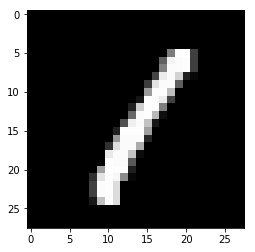

In [3]:
plt.imshow(x_train[3], cmap='gray')
print(y_train[3])

In [4]:
# Let's create our traditional NN
nn = keras.models.Sequential([
    keras.layers.Flatten(), # Flatten the 28x28 images
    keras.layers.Dense(518, activation=tf.nn.relu), # First hidden layer, 512 neurons, ReLU activation
    keras.layers.Dense(10, activation=tf.nn.softmax) # output Layer, 10 categories (0-9) and softmax activation
])

In [5]:
# Compile, fit and evaluate our model
nn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn.fit(x_train, y_train, epochs=5)
nn.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 13s 214us/step - loss: 0.1973 - acc: 0.9416
Epoch 2/5
60000/60000 [==============================] - 10s 162us/step - loss: 0.0800 - acc: 0.9758
Epoch 3/5
60000/60000 [==============================] - 12s 192us/step - loss: 0.0535 - acc: 0.9830
Epoch 4/5
60000/60000 [==============================] - 11s 178us/step - loss: 0.0353 - acc: 0.9887
Epoch 5/5
10000/10000 [==============================] - 1s 53us/step


[0.06767449411806592, 0.9801]

In [5]:
# Okay, let's now create a cNN without using Keras API
def create_model(training):
    # First, reshape ou 28x28 graymap images to 28x28x1 (single channel)
    reshape = tf.reshape(X, [-1, 28,28, 1])
    # Two convolutions layers with ReLU activation
    conv_1 = tf.layers.conv2d(reshape, activation=tf.nn.relu, filters=32, kernel_size=(3,3))
    conv_2 = tf.layers.conv2d(conv_1, activation=tf.nn.relu, filters=64, kernel_size=(3,3))
    # Max Pooling layer
    pool_1 = tf.layers.max_pooling2d(conv_2, pool_size=(2,2), strides=(1,1))
    # Dropout to mitigate overfitting
    dropout_1 = tf.layers.dropout(pool_1, rate=0.25, training=training)
    # Flatten results for dense layers
    flat_1  = tf.layers.flatten(dropout_1)
    # Dense (Fully connected) layer
    dense_1 = tf.layers.dense(flat_1, units=128, activation='relu')
    # Output has 10 classes
    output = tf.layers.dense(dense_1, units=10, activation='softmax', name='output')
    return output

In [6]:
def init_model(model, labels):
    # Mean crossentropy as the loss function
    xentropy =  keras.losses.sparse_categorical_crossentropy(y_pred=model, y_true=labels)
    loss = tf.reduce_mean(xentropy)
    # Setting our optmizer parameters
    optmizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9)
    training_op = optmizer.minimize(loss)
    return training_op

In [7]:
# Defining our placeholders 
# Input is a lot of images (None) with dimensions 28x28, 
# the channel dimensions is set by the reshape layer in the model
X = tf.placeholder(tf.float32, shape=[None, 28, 28])
# Output shape can be infered
y = tf.placeholder(tf.int32, shape=[None])
# Are we training the model? Used by the dropout layer
training = tf.placeholder(tf.bool)
# Create the model
model = create_model(training)

In [8]:
# Initializing our model
final_model = init_model(model, y)

In [9]:
# running TF training
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)
# Accuracy logging
correct = tf.nn.in_top_k(model, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [10]:
def yield_mb(x, y, batchsize=1000):
    batches = int(len(x)/batchsize)
    for i in range(batches):
        yield (x[i*batchsize:(i+1)*batchsize], y[i*batchsize:(i+1)*batchsize])

In [13]:
%%time
# Main training loop: 57s
for test_data, test_label in yield_mb(x_test, y_test, batchsize=2000):
    for data, label in yield_mb(x_train, y_train, batchsize=64):
        # Make sure to run the `final_model` as it includes the optmization step
        session.run(final_model, feed_dict={X: data, y: label, training: True})
    # Log
    acc_train = session.run(accuracy, feed_dict={X: test_data, y: test_label, training: True})
    print("Train accuracy:", acc_train)

Train accuracy: 0.9855
Train accuracy: 0.979
Train accuracy: 0.9895
Train accuracy: 0.996
Train accuracy: 0.992
CPU times: user 41min 34s, sys: 3min 13s, total: 44min 48s
Wall time: 23min 19s
